In [5]:
#%%
from functools import partial
import numpy as np
import os, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as dataclass
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from yaml import MarkedYAMLError
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

num_samples=6
max_num_epochs=40
config = {
    # "lr": tune.loguniform(1e-4, 1e-2),
    "lr": tune.choice([0.0001]),
    "batch_size": tune.choice([4, 8])
}

class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        # net = models.vgg16_bn(pretrained=True)
        # for vgg net
        
        conv_1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=3), 
                                nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2, stride=2))
        conv_2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=3), 
                                nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2, stride=2))
        conv_3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=3), 
                                nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2, stride=2))
        conv_4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=3), 
                                nn.ReLU())
        tran_conv_1 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)), 
                                nn.ReLU())
        tran_conv_2 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=(2, 3), stride=(2, 2)), 
                                nn.ReLU())
        tran_conv_3 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=(2, 3), stride=(2, 2)), 
                                nn.ReLU())
        out = nn.Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.out = nn.Sequential(conv_1, conv_2, conv_3, conv_4, tran_conv_1, tran_conv_2, tran_conv_3, out)

    def forward(self, x):
        x = self.out(x)
        return x

class Displacement_dataset(dataclass.Dataset):
    def __init__(self, root, transform):
        self.transform = transform
        self.data = os.listdir(f'{root}/data')
        self.data = [f'{root}/data/{i}' for i in self.data]
        self.label = os.listdir(f'{root}/label')
        self.label = [f'{root}/label/{i}' for i in self.label]
        assert len(self.data) == len(self.label), 'data and label numbers are different.'

    def __getitem__(self, index):
        data  = np.load(self.data[index]).astype(np.float32)
        label = np.load(self.label[index]).astype(np.float32)
        data = self.transform(data)
        label = self.transform(label)
        return data, label
    
    def __len__(self):
        return len(self.data)

def load_data(data_dir="./"):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    val_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dir = data_dir + '/training'
    train_datasets = Displacement_dataset(train_dir, transform=train_transform)

    val_dir = data_dir + '/validation'
    val_datasets = Displacement_dataset(val_dir, transform=val_transform)

    return train_datasets, val_datasets

def train_cifar(config, checkpoint_dir=None, data_dir=None, max_epoch=20):
    # confusion = np.zeros((4, 4))
    
    fold_loss = 0.0
    net = myNet()
    if torch.cuda.is_available():
        net.cuda()
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    criterion = nn.MSELoss()
    # optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    optimizer = optim.Adam(net.parameters(), lr=1e-4)

    trainset, valset = load_data(data_dir=data_dir)
    train_dataloader = torch.utils.data.DataLoader(trainset, 
        batch_size=4, 
        shuffle=True,
        num_workers=0)
    
    val_dataloader = torch.utils.data.DataLoader(valset, 
        batch_size=4, 
        shuffle=True,
        num_workers=0)

    for epoch in range(max_epoch):
        running_loss = 0.0
        running_acc = 0.0
        epoch_steps = 0
        for img, label in tqdm(train_dataloader):
            inputs = img.cuda()
            labels = label.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_correct = loss

            loss.backward()
            optimizer.step()

            # print statistics
            running_acc += train_correct.item()
            running_loss += loss.item()
        
        Loss = float(running_acc / (len(trainset)))


        
        print(len(trainset))
        # Acc = float(running_acc / (len(trainset)))
        print(f"epoch: {epoch+1}")
        print("Train Loss:%.9f" % Loss)
        # print("Train Accuracy:%.9f" % Acc)

    net.eval()
    torch.cuda.empty_cache()
    # Validation loss
    val_loss = 0.0
    val_acc = 0.0
    for img, label in val_dataloader:
        inputs = img.cuda()
        labels = label.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_correct = loss
        val_acc += val_correct.item()

    # with tune.checkpoint_dir(0) as checkpoint_dir:
    #     path = os.path.join(checkpoint_dir, "checkpoint")
    #     torch.save((net.state_dict(), optimizer.state_dict()), path)

    Loss = float(val_loss / (len(valset)))
    # Acc = float(val_acc / (len(valset)))
    print("Validation Loss:%.9f" % Loss)
    # print("Validation Accuracy:%.9f; correct number:%d; total: %d" % (Acc, val_acc, len(valset)))
    # tune.report(loss=Loss)
    print("Finished")
    
    torch.cuda.empty_cache()
    torch.save(net.state_dict(), r'C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\displacement_estimation\model.pt')
    return net

gpus_per_trial=1
data_dir = os.path.abspath(r"C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\displacement_estimation")
net = train_cifar(config=config, data_dir=data_dir, max_epoch=max_num_epochs)

# scheduler = ASHAScheduler(
#     metric="loss",
#     mode="min",
#     max_t=max_num_epochs,
#     grace_period=1,
#     reduction_factor=2)
# reporter = CLIReporter(
#     # parameter_columns=["l1", "l2", "lr", "batch_size"],
#     metric_columns=["loss", "accuracy", "training_iteration"])
# result = tune.run(
#     partial(train_cifar, data_dir=data_dir, max_epoch=max_num_epochs),
#     resources_per_trial={"cpu": 8, "gpu": gpus_per_trial},
#     config=config,
#     num_samples=num_samples,
#     scheduler=scheduler,
#     progress_reporter=reporter)

# best_trial = result.get_best_trial("loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(
#     best_trial.last_result["loss"]))
# print("Best trial final validation accuracy: {}".format(
#     best_trial.last_result["accuracy"]))



100%|██████████| 1124/1124 [05:24<00:00,  3.47it/s]


4496
epoch: 1
Train Loss:44.098964486


100%|██████████| 1124/1124 [05:35<00:00,  3.35it/s]


4496
epoch: 2
Train Loss:36.729040837


100%|██████████| 1124/1124 [05:28<00:00,  3.42it/s]


4496
epoch: 3
Train Loss:36.179461440


100%|██████████| 1124/1124 [05:22<00:00,  3.49it/s]


4496
epoch: 4
Train Loss:35.806909722


100%|██████████| 1124/1124 [05:21<00:00,  3.50it/s]


4496
epoch: 5
Train Loss:35.557630139


100%|██████████| 1124/1124 [05:21<00:00,  3.49it/s]


4496
epoch: 6
Train Loss:35.180919935


100%|██████████| 1124/1124 [05:22<00:00,  3.49it/s]


4496
epoch: 7
Train Loss:34.657485939


100%|██████████| 1124/1124 [05:22<00:00,  3.48it/s]


4496
epoch: 8
Train Loss:33.906429010


100%|██████████| 1124/1124 [05:22<00:00,  3.49it/s]


4496
epoch: 9
Train Loss:33.364686817


100%|██████████| 1124/1124 [05:22<00:00,  3.48it/s]


4496
epoch: 10
Train Loss:32.945538063


100%|██████████| 1124/1124 [05:22<00:00,  3.48it/s]


4496
epoch: 11
Train Loss:32.698606673


100%|██████████| 1124/1124 [05:22<00:00,  3.48it/s]


4496
epoch: 12
Train Loss:32.459996388


100%|██████████| 1124/1124 [05:22<00:00,  3.49it/s]


4496
epoch: 13
Train Loss:32.319687154


100%|██████████| 1124/1124 [05:22<00:00,  3.49it/s]


4496
epoch: 14
Train Loss:31.997092177


100%|██████████| 1124/1124 [05:22<00:00,  3.48it/s]


4496
epoch: 15
Train Loss:31.780479784


100%|██████████| 1124/1124 [05:22<00:00,  3.48it/s]


4496
epoch: 16
Train Loss:31.516906417


100%|██████████| 1124/1124 [05:23<00:00,  3.47it/s]


4496
epoch: 17
Train Loss:31.311310691


100%|██████████| 1124/1124 [05:22<00:00,  3.49it/s]


4496
epoch: 18
Train Loss:31.178641511


100%|██████████| 1124/1124 [05:21<00:00,  3.50it/s]


4496
epoch: 19
Train Loss:31.008093011


100%|██████████| 1124/1124 [05:22<00:00,  3.48it/s]


4496
epoch: 20
Train Loss:30.845100746
Validation Loss:32.734215658
Finished


In [ ]:
import torch
import numpy as np
import scipy.io as matlabio
import matplotlib.pyplot as plt
import importlib
import glob
import myLib
importlib.reload(myLib)

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())
print(torch.cuda.max_memory_reserved())

data_path = glob.glob(r'C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\displacement_estimation\validation\data\*.npy')
label_path = glob.glob(r'C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\displacement_estimation\validation\label\*.npy')
mse_val = np.zeros(len(data_path))
mse_without_push = np.zeros(len(data_path))
for i in range(len(data_path)):
    data = np.load(data_path[i]).reshape((1, 1, 1000, 995)).astype(np.float32)
    data = torch.tensor(data)
    output = net(data).detach().numpy()
    label = np.load(label_path[i])
    mse_val[i] = ((output-label)**2).mean(axis=1).mean()
    output = np.reshape(output, (1000, 5, 199))
    label = np.reshape(label, (1000, 5, 199))
    output = output[:, 1:4, 15:].reshape((1000, 184*3))
    label = label[:, 1:4, 15:].reshape((1000, 184*3))
    mse_without_push[i] = ((output-label)**2).mean(axis=1).mean()


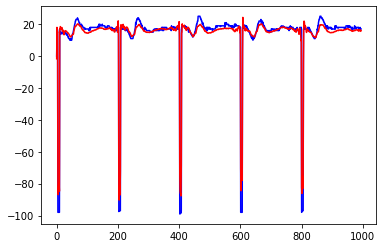

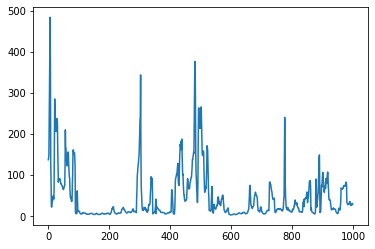

In [6]:
import torch
import numpy as np
import scipy.io as matlabio
import matplotlib.pyplot as plt
import importlib
import glob
import myLib
importlib.reload(myLib)
data = np.load(r'C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\displacement_estimation\training\data\2.npy')
label = np.load(r'C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\displacement_estimation\training\label\2.npy');

data = data.reshape((1, 1, 1000, 995)).astype(np.float32)
data = torch.tensor(data)
net.cpu()
output = net(data).detach().numpy()
x = np.arange(995)
output = output.squeeze()
# myLib.output_data({'output':output, 'label':label}, dir=r'C:\Users\Buslab\Desktop\Experiment data\DaMing\contusion\displacement_estimation')
mse = ((output - label)**2).mean(axis=1)
# plt.axis([0, 1000, 5, 30])
plt.plot(x, label[328, :], 'b')
plt.plot(x, output[328, :], 'r')
plt.show()

plt.plot(mse)
